In [1]:
import numpy as np
import numpy.linalg as la
import scipy.linalg as scla
import scipy as sc
import math as math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pylab as P
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
def plotMatrix(Ai, normtype):
    #normtype 1 normalizes whole matrix
    #normtype 2 normalizes rows of matrix
    
    N, M = Ai.shape
  
    if(normtype == 1):
        norm = np.max(abs(Ai))
        A = Ai/(norm*2)
    elif(normtype == 2):
        A = Ai*1.
        for i in range(0, N, 1):
            norm = np.max(abs(Ai[i,]))
            A[i,] = Ai[i,]/(norm*2)
    
    t = np.arange(1, M+1, 1)
    for i in range(0, N, 1):
        base = A[i,]*0.
        base.fill(N-i)
        plt.fill_between(t, base, A[i,]+base)
    plt.ylim(0,N+1)
    plt.axis('off')
    
def MLsol(A, Cdi, d):
    aci = np.dot(A.T, Cdi)
    D = np.dot(aci, A)
    Di = la.inv(D)
    F = np.dot(aci,d)
    m = np.dot(Di, F) # ----------------  m = [A.T * Cd^-1 * A]^-1  * A.T * Cd^-1 * d 
    
    amd = np.dot(A, m) - d
    chicken = np.dot(np.dot(amd.T, Cdi), amd) #Calculate misfit
    return m, chicken

In [3]:
#Forward Problem
stn = [[-150., 100., -0.1],
      [200., 50., -0.2],
      [300., -150., -0.1],
      [20., -50., -0.3],
      [-100., -250., -0.4]]

v = 5.5
mt = [0., 0., 30., 10.]
t = np.zeros(5)
for i, s in enumerate(stn):
    X = (mt[0] - s[0])**2
    Y = (mt[1] - s[1])**2
    Z = (mt[2] - s[2])**2
    t[i] = mt[3] + np.sqrt(X+Y+Z)/v + np.random.normal(0, 0.1)
    
Cdi = np.zeros((5,5))
np.fill_diagonal(Cdi, 100)

def getdata(m):
    stn = [[-150., 100., -0.1],
          [200., 50., -0.2],
          [300., -150., -0.1],
          [20., -50., -0.3],
          [-100., -250., -0.4]]    
    v = 5.5    
    d = np.zeros(5)
    for i, s in enumerate(stn):
        X = (m[0] - s[0])**2
        Y = (m[1] - s[1])**2
        Z = (m[2] - s[2])**2
        d[i] = m[3] + np.sqrt(X+Y+Z)/v
    return d
        
def jacob(m, stn):
    M = 5
    N = len(m)
    A = np.zeros((M, N))
    for i in range(0, M):
        X = (m[0] - stn[i][0])
        Y = (m[1] - stn[i][1])
        Z = (m[2] - stn[i][2])
        den = v*np.sqrt( X**2 + Y**2 + Z**2 )
        A[i][0] = X/den
        A[i][1] = Y/den
        A[i][2] = Z/den
        A[i][3] = 1.
    return A

In [4]:
mo = [10.0, -10.0, 10., 20.]

A = jacob(mo, stn)
d = getdata(mo)
dt = t-d
dm, chi2 = MLsol(A, Cdi, dt)

m1 = mo+dm
A1 = jacob(m1, stn)
d1 = getdata(m1)
dt1 = t-d1
dm1, chi21 = MLsol(A1, Cdi, dt1)
m = m1+dm1

mlist = np.vstack([mo, m1, m])
chilist = np.array([chi2, chi21])
dmlist = np.vstack([dm, dm1])
count = 1

while((np.dot(dm.T, dm)> 0.0000000000001 or abs(chilist[count-1]-chilist[count]) > 0.000000000001) and count < 100000):
    A = jacob(m, stn)
    d = getdata(m)
    dt = t-d
    dm, chi2 = MLsol(A, Cdi, dt)
    dm = dm
    mlist = np.vstack([mlist, m+dm])
    dmlist = np.vstack([dmlist, dm])
    chilist = np.append(chilist, [chi2])
    m = m + dm
    count+=1
print m
print mlist.shape
print chilist
print la.inv(np.dot(np.dot(A.T, Cdi), A))

[  0.22394672  -0.58664318  31.96350516   9.90976892]
(7L, 4L)
[ 0.76661003  0.10430584  0.08595465  0.08587582  0.08587581  0.08587581]
[[  1.26851431e-01   2.13584038e-02  -2.22454907e-02   4.30782450e-03]
 [  2.13584038e-02   2.05576269e-01  -2.38164181e-01  -2.75356654e-04]
 [ -2.22454907e-02  -2.38164181e-01   2.78062589e+00  -9.63231948e-02]
 [  4.30782450e-03  -2.75356654e-04  -9.63231948e-02   5.88690013e-03]]


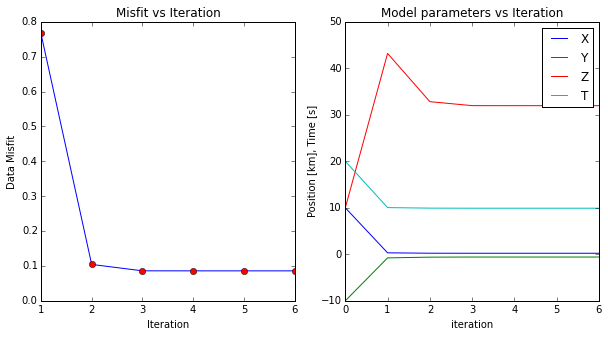

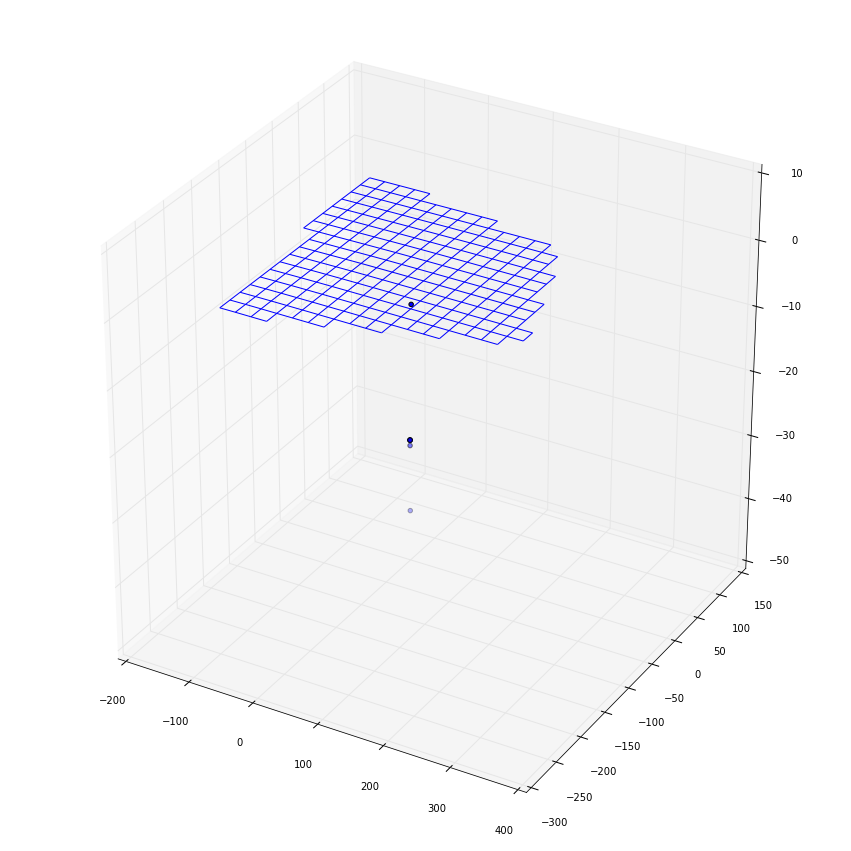

In [5]:
county = np.arange(1, count+2)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(county, chilist)
plt.plot(county, chilist, 'ro')
plt.title('Misfit vs Iteration')
plt.ylabel('Data Misfit')
plt.xlabel('Iteration')

county = np.arange(0, count+2)

plt.subplot(122)
plt.plot(county, mlist[:,0], label='X')
plt.plot(county, mlist[:,1], label='Y')
plt.plot(county, mlist[:,2], label='Z')
plt.plot(county, mlist[:,3], label='T')
plt.title('Model parameters vs Iteration')
plt.xlabel('iteration')
plt.ylabel('Position [km], Time [s]')
plt.legend()
plt.savefig('a5q1a.pdf')

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(m[0], m[1], -1*m[2], c='r')
ax.scatter(mlist[:,0], mlist[:,1], -1*mlist[:,2])

x = np.linspace(-150.,300,20)
y = np.linspace(-250,100,20)
X,Y=np.meshgrid(x,y)
stnt = np.transpose(np.array(stn))
Zi = mlab.griddata(stnt[0], stnt[1], stnt[2], X, Y, interp='nn')
ax.plot_wireframe(X, Y, -1*Zi)

In [6]:
mo = [30, -40, 9, 20]

A = jacob(mo, stn)
d = getdata(mo)
dt = t-d
dm, chi2 = MLsol(A, Cdi, dt)

m1 = mo+dm
A1 = jacob(m1, stn)
d1 = getdata(m1)
dt1 = t-d1
dm1, chi21 = MLsol(A1, Cdi, dt1)
m = m1+dm1

mlist = np.vstack([mo, m1, m])
chilist = np.array([chi2, chi21])
count = 1

while((np.dot(dm.T, dm)> 0.0001 or chilist[count-1]-chilist[count] > 0.0001) and count < 10000):
    A = jacob(m, stn)
    d = getdata(m)
    dt = t-d
    dm, chi2 = MLsol(A, Cdi, dt)
    mlist = np.vstack([mlist, m+dm])
    chilist = np.append(chilist, [chi2])
    m = m+dm
    count+=1
print m
print chilist
print la.inv(np.dot(np.dot(A.T, Cdi), A))

[  0.22394673  -0.58664318  31.96350525   9.90976892]
[ 51.65060014   1.09744721   0.08764083   0.08587911   0.08587581]
[[  1.26851494e-01   2.13583869e-02  -2.22455891e-02   4.30783654e-03]
 [  2.13583869e-02   2.05576377e-01  -2.38161157e-01  -2.75377575e-04]
 [ -2.22455891e-02  -2.38161157e-01   2.78058305e+00  -9.63227114e-02]
 [  4.30783654e-03  -2.75377575e-04  -9.63227114e-02   5.88691733e-03]]


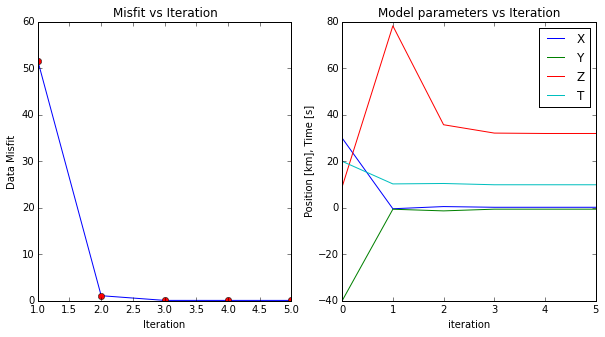

In [7]:
county = np.arange(1, count+2)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(county, chilist)
plt.plot(county, chilist, 'ro')
plt.title('Misfit vs Iteration')
plt.ylabel('Data Misfit')
plt.xlabel('Iteration')

county = np.arange(0, count+2)

plt.subplot(122)
plt.plot(county, mlist[:,0], label='X')
plt.plot(county, mlist[:,1], label='Y')
plt.plot(county, mlist[:,2], label='Z')
plt.plot(county, mlist[:,3], label='T')
plt.title('Model parameters vs Iteration')
plt.xlabel('iteration')
plt.ylabel('Position [km], Time [s]')
plt.legend()
plt.savefig('a5q1b.pdf')

x = np.linspace(-150.,300,20)
y = np.linspace(-250,100,20)
X,Y=np.meshgrid(x,y)
stnt = np.transpose(np.array(stn))
Zi = mlab.griddata(stnt[0], stnt[1], stnt[2], X, Y, interp='nn')
ax.plot_wireframe(X, Y, -1*Zi)

In [8]:
mo = [60, -100, 19, 20]

A = jacob(mo, stn)
d = getdata(mo)
dt = t-d
dm, chi2 = MLsol(A, Cdi, dt)

m1 = mo+dm
A1 = jacob(m1, stn)
d1 = getdata(m1)
dt1 = t-d1
dm1, chi21 = MLsol(A1, Cdi, dt1)
m = m1+dm1

mlist = np.vstack([mo, m1, m])
chilist = np.array([chi2, chi21])
count = 1

while((np.dot(dm.T, dm)> 0.001 or chilist[count-1]-chilist[count] > 0.01) and count < 10000):
    A = jacob(m, stn)
    d = getdata(m)
    dt = t-d
    dm, chi2 = MLsol(A, Cdi, dt)
    mlist = np.vstack([mlist, m+dm])
    chilist = np.append(chilist, [chi2])
    m = m+0.5*dm
    count+=1
print count,
print m
print la.inv(np.dot(np.dot(A.T, Cdi), A))

16 [  0.22416057  -0.58717168  31.97384935   9.91883972]
[[  1.26855199e-01   2.13570249e-02  -2.22492438e-02   4.30849901e-03]
 [  2.13570249e-02   2.05582500e-01  -2.37982088e-01  -2.76546321e-04]
 [ -2.22492438e-02  -2.37982088e-01   2.77800261e+00  -9.62922292e-02]
 [  4.30849901e-03  -2.76546321e-04  -9.62922292e-02   5.88785322e-03]]


16
[  0.22416057  -0.58717168  31.97384935   9.91883972]
[  6.94104302e+02   1.43688382e+03   2.35583643e+03   5.09311759e+01
   1.93121350e+00   3.04296628e-01   1.29227012e-01   9.63880800e-02
   8.85586120e-02   8.65626092e-02   8.60503713e-02   8.59198860e-02
   8.58868936e-02   8.58785924e-02   8.58765096e-02   8.58759877e-02
   8.58758571e-02]


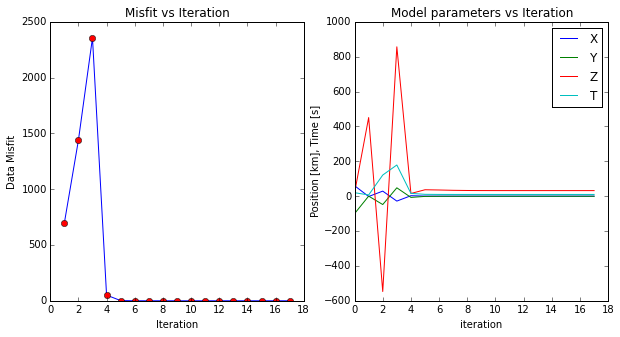

In [9]:
print count
print m
print chilist

county = np.arange(1, count+2)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(county, chilist)
plt.plot(county, chilist, 'ro')
plt.title('Misfit vs Iteration')
plt.ylabel('Data Misfit')
plt.xlabel('Iteration')

county = np.arange(0, count+2)

plt.subplot(122)
plt.plot(county, mlist[:,0], label='X')
plt.plot(county, mlist[:,1], label='Y')
plt.plot(county, mlist[:,2], label='Z')
plt.plot(county, mlist[:,3], label='T')
plt.title('Model parameters vs Iteration')
plt.xlabel('iteration')
plt.ylabel('Position [km], Time [s]')
plt.legend()
plt.savefig('a5q1b2.pdf')

[ 1  4 15  2]


In [18]:
mo = [30, -40, 9, 20]

A = jacob(mo, stn)
d = getdata(mo)
dprime = t-d+np.dot(A,mo)
m1, chi2 = MLsol(A, Cdi, dprime)

A1 = jacob(m1, stn)
dprime1 = t-d+np.dot(A1, m1)
dt1 = t-d1
m, chi21 = MLsol(A1, Cdi, dprime1)

mlist = np.vstack([mo, m1, m])
chilist = np.array([chi2, chi21])
count = 1

while((np.dot(dm.T, dm)> 0.0001 or chilist[count-1]-chilist[count] > 0.0001) and count < 10000):
    A = jacob(m, stn)
    d = getdata(m)
    dprime = t-d+np.dot(A, m)
    m, chi2 = MLsol(A, Cdi, dprime)
    mlist = np.vstack([mlist, m])
    chilist = np.append(chilist, [chi2])
    m
    dm = mlist[count] - m
    count+=1
print m
print chilist
print la.inv(np.dot(np.dot(A.T, Cdi), A))

[  0.22394672  -0.58664318  31.96350516   9.90976892]
[ 51.65060014  47.91514737  16.92454871   1.35113047   0.08588066
   0.08587583   0.08587581   0.08587581]
[[  1.26851431e-01   2.13584038e-02  -2.22454907e-02   4.30782450e-03]
 [  2.13584038e-02   2.05576269e-01  -2.38164181e-01  -2.75356654e-04]
 [ -2.22454907e-02  -2.38164181e-01   2.78062589e+00  -9.63231948e-02]
 [  4.30782450e-03  -2.75356654e-04  -9.63231948e-02   5.88690013e-03]]
